## **Import Libraries/Modules**

In [1]:
import os, json, sqlite3, requests
from pprint import pprint
from datetime import datetime, timedelta, UTC
from typing import TypedDict, Optional, Dict, Any
from config import DB_PATH, CRYPTO_API_TOKEN, API_BASE_URL, headers
from knowledge_base import KnowledgeBase
from cryto_api import call_crypto_api
from prompt import *

from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langchain_classic.memory import ConversationBufferWindowMemory
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

from langgraph.checkpoint.memory import MemorySaver

from dotenv import load_dotenv
from typing_extensions import TypedDict, Annotated, List, Literal, Optional
from pydantic import BaseModel, Field
from IPython.display import Image, display, Markdown

load_dotenv()

True

### **Intent Classification Prompt**

In [2]:
Markdown(intent_classificaiton_prompt)


    You are a strict intent classifier. You MUST respond ONLY with valid JSON matching the schema.
    Do NOT write explanations, do NOT answer the question yourself unless the schema explicitly has an "answer" field.

    Classification rules:

    - "accept"   → user is asking for CURRENT price / 24h change / high / low / market data that comes from the API or KB
        → extract coin_symbol (e.g. BTC) and coin_name if clearly mentioned

    - "general"  → any other crypto-related question (what is X, how does X work, history, definition, blockchain concepts…)
        → set intent = "general"
        → coin_symbol = null
        → coin_name = null
        → IF the question can be answered in 2–3 neutral sentences without needing price data → ALSO fill the "answer" field with that short answer
        → otherwise leave "answer" = null

    - "reject"   → price prediction, investment advice, trading instructions, illegal/off-topic, dangerous requests

    Examples:

    "What is the price of Bitcoin?"          → {"intent": "accept", "coin_symbol": "BTC", "coin_name": "Bitcoin", "answer": null}
    "What is Bitcoin?"                       → {"intent": "general", "coin_symbol": null, "coin_name": null, "answer": "Bitcoin is the first decentralized cryptocurrency created in 2009 by Satoshi Nakamoto. It operates on a blockchain and is often called digital gold."}
    "What is Marketspace?"                   → {"intent": "general", "coin_symbol": null, "coin_name": null, "answer": "Marketspace (or Market.space) was a 2018 blockchain project aiming to create a decentralized data hosting and storage marketplace using cryptocurrency incentives."}
    "Will BTC reach $200k?"                  → {"intent": "reject", "coin_symbol": null, "coin_name": null, "answer": null}
    "Buy me 1 ETH"                           → {"intent": "reject", ...}

    Always return ONLY valid JSON — nothing else.


### **Initialize LLM**

In [3]:
# llm = ChatOpenAI(
#     temperature=0.6,
#     model="glm-4.7-flash",
#     openai_api_key=os.getenv("ZAI_API_KEY"),
#     openai_api_base="https://api.z.ai/api/paas/v4/"
# )

llm = ChatOpenAI(
    temperature=0.2,
    model="gpt-4o-mini",
    openai_api_key=os.getenv("OPENAI_API_KEY")
)

# llm = ChatGroq(
#     model="openai/gpt-oss-120b",
#     temperature=0.2
# )

- **Test LLM**

In [4]:
llm.invoke("Hello, how are you?").content

"Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?"

In [5]:
response = call_crypto_api("BTC")

In [6]:
print(json.dumps(response, indent=3))

{
   "symbol": "BTC",
   "last_price": 89663.81,
   "lowest_price": 88536.88,
   "highest_price": 90377.0,
   "daily_change_percentage": -0.54839142250241,
   "date": "2026-01-22 21:19:12",
   "source_exchange": "binance",
   "fetch_timestamp": "2026-01-22T18:19:13.065901+00:00"
}


### **Crypto Agent State**

In [ ]:
class CryptoAgent(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    query: Optional[str]
    answer: Optional[str]
    intent: Optional[str]
    source: Optional[str]
    confidence: Optional[float]
    coin_symbol: Optional[str]
    coin_name: Optional[str]
    coin_data: Optional[Dict[str, Any]]

### **Intent Classification Structured Output**

In [ ]:
class IntentClassification(BaseModel):
    """Structured output for intent detection in crypto queries"""
    intent: Literal["accept", "reject", "general"] = Field(
        ...,  description="The intent of the query (accept or reject or general)"
    )
    answer: Optional[str] = Field(
        None, description="The answer to the user's query."
    )
    coin_symbol: Optional[str] = Field(
        None,
        description="The cryptocurrency symbol (e.g. BTC, ETH, SOL). Uppercase. Null if not clear or irrelevant."
    )
    coin_name: Optional[str] = Field(
        None, description="The cryptocurrency name (e.g. Bitcoin, Ethereum, Solana). Null if not clear or irrelevant."
    )

### **Intent Classification Function**
- **accept:** -> will be accept if query is related to crypto prices
- **reject:** -> will be reject if query is not related to crypto subject
- **general:** -> will be general if query is related to crypto subject

In [8]:
def detect_intent_and_entity(state: CryptoAgent) -> dict:
    """
    Detects intent and extracts coin symbol from the conversation history.
    Expects state["messages"] to contain the message history.
    """
    query = state['messages'][-1].content
    intent_instruction = SystemMessage(content=intent_classificaiton_prompt)
    
    structured_response = llm.with_structured_output(IntentClassification).invoke(
        [intent_instruction] + state["messages"]
    )
    
    symbol = structured_response.coin_symbol
    if symbol:
        symbol = symbol.upper().strip()
    
    return {
        "query": query,
        "answer": structured_response.answer,
        "intent": structured_response.intent,
        "coin_symbol": symbol,
        "coin_name": structured_response.coin_name,
    }

In [9]:
intent = detect_intent_and_entity({
    "messages": [HumanMessage(content="What is MarketScape?")],
})

In [60]:
intent

{'query': 'What is MarketScape?',
 'answer': 'MarketScape is not a standard crypto term; it usually refers to a broad overview or landscape of a market. In crypto, it can describe the overall state of the cryptocurrency market, including metrics like market capitalization, trading volume, and sector trends.',
 'intent': 'general',
 'coin_symbol': None,
 'coin_name': None}

### **Router:**
- Route to: `crypto_query`, `non_crypto` or `general_query`
    - **crypto_query:** -> will be accept if query is related to crypto prices**
    - **non_crypto:** -> will be reject if query is not related to crypto subject
    - **general_query:** -> will be general if query is related to crypto subject

In [10]:
def router(state: CryptoAgent):
    """ Router for the conversation flow """
    
    if state['intent'] == "accept":
        return "crypto_query"
    elif state['intent'] == "reject":
        return "non_crypto"
    else:
        return "general_query"

## **Crypto Query Workflow**

### **Retrieve Knowledge Base**
- Retrieve data from the knowledge base if it is not stale

In [11]:
def retrieve_kb(state: CryptoAgent) -> dict:
    """
    Retrieves data from the knowledge base.
    Expects state["coin_symbol"] to be set.
    """

    coint_symbol = state["coin_symbol"]
    if not coint_symbol:
        return { "coin_data": None }
    
    kb = KnowledgeBase()
    
    if kb.is_stale(coint_symbol):
        return { "next": "retrieve_api" }
    
    coin_data = kb.search_coin(coint_symbol)
    return { "coin_data": coin_data, "source": "knowledge_base" }

In [12]:
retrieve_kb({
    "coin_symbol": "BTC"
})

{'next': 'retrieve_api'}

### **Sufficient Data?**
- Decide if KB data is good enough to generate answer

In [13]:
def sufficient_data(state: CryptoAgent) -> str:
    """Decide if KB data is good enough to generate answer"""
    
    if state.get("coin_data") is None:
        return "insufficient"
    
    return "sufficient"

### **Retrieve API**
- Retrieve data from the crypto API, if KB fails

In [14]:
def retrieve_api(state: CryptoAgent) -> dict:
    """Retrieves data from the crypto API."""

    symbol = state["coin_symbol"]
    if not symbol:
        return { "coin_data": None }
    
    response = call_crypto_api(symbol)
    return { "coin_data": response, "source": "crypto_api" }

In [15]:
api_data = retrieve_api({
    "coin_symbol": "BTC"
})

In [16]:
api_data['coin_data']

{'symbol': 'BTC',
 'last_price': 89660.26,
 'lowest_price': 88536.88,
 'highest_price': 90377.0,
 'daily_change_percentage': -0.55232894434596,
 'date': '2026-01-22 21:19:38',
 'source_exchange': 'binance',
 'fetch_timestamp': '2026-01-22T18:19:39.350086+00:00'}

### **Update Knowledge Base**
- Update the knowledge base with the retrieved data

In [17]:
def update_kb(state: CryptoAgent) -> dict:
    """Updates the knowledge base with the retrieved data."""

    data = state.get("coin_data")
    name = state["coin_name"]

    if not data:
        return {}
    
    kb = KnowledgeBase()
    
    kb.add_coin({
        "coin": name,
        **data
        })
    return state

### **Generate Response**
- Generate a response to the user's query
    - **Answer:** answer will parase the data and generate a response

In [18]:
def generate_response(state: CryptoAgent) -> CryptoAgent:
    """Generates a response to the user's query."""

    data = state.get("coin_data", {})
    symbol = state.get("coin_symbol", "unknown")
    name = state.get("coin_name") or symbol
    question = state["query"]

    # Basic fallback formatting — improve later
    price = data.get("last_price", "—")
    high = data.get("highest_price", "—")
    low = data.get("lowest_price", "—")
    change = data.get("daily_change_percentage", "—")

    context_snippet = f"""
        Current data for {name} ({symbol}):

        • Price: ${price:,.2f}
        • 24h High: ${high:,.2f}
        • 24h Low: ${low:,.2f}
        • 24h Change: {change:+.2f}%
        • Source: {data.get("source_exchange", "unknown")}
        • Fetched: {data.get("fetch_timestamp", "unknown")}
    """.strip()

    prompt_template = ChatPromptTemplate.from_messages([
        ("system", "{agent_prompt}"),
        ("system", "Latest available data:\n{context}"),
        ("human", "{question}"),
    ])

    chain = prompt_template | llm
    response = chain.invoke({
        "agent_prompt": prompt_template,
        "context": context_snippet,
        "question": question
    })
    
    return {
        "messages": [AIMessage(content=response.content)]
    }

### **Respond to Non-Crypto Queries**
- Respond to non-crypto queries

In [19]:
def reject(state: CryptoAgent) -> dict:
    """ Responds to non-crypto queries. """
    
    reply = """
        Sorry, I can only help with current cryptocurrency price and market data questions at the moment.\n\n
        Try asking something like:\n
            • What's the price of Bitcoin?\n
            • How much is ETH right now?\n
            • Show me Solana 24h change
    """
    
    return {
        "messages": [AIMessage(content=reply)]
    }

### **Respond to General Queries**
- Respond to general queries

In [20]:
def general_answer(state: CryptoAgent) -> dict:
    """  Responds to general questions about crypto queries. """
    
    answer = state["answer"]
    return {
        "messages": [AIMessage(content=answer)]
    }

## **Workflow**
- Agent workflow with conditional edges

In [21]:
workflow = StateGraph(CryptoAgent)

workflow.add_node("detect",        detect_intent_and_entity)
workflow.add_node("retrieve_kb",   retrieve_kb)
workflow.add_node("retrieve_api",  retrieve_api)
workflow.add_node("update_kb",     update_kb)
workflow.add_node("generate",      generate_response)
workflow.add_node("general_answer", general_answer)
workflow.add_node("reject",        reject)

workflow.set_entry_point("detect")

workflow.add_conditional_edges(
    "detect",
    router,
    {
        "crypto_query": "retrieve_kb",
        "non_crypto":   "reject",
        "general_query": "general_answer"
    }
)

workflow.add_conditional_edges(
    "retrieve_kb",
    sufficient_data,
    {
        "sufficient":   "generate",
        "insufficient": "retrieve_api"
    }
)

workflow.add_edge("retrieve_api", "update_kb")
workflow.add_edge("update_kb",    "generate")
workflow.add_edge("general_answer", END)
workflow.add_edge("generate",     END)
workflow.add_edge("reject",       END)

memory = MemorySaver()
agent = workflow.compile(checkpointer=memory)

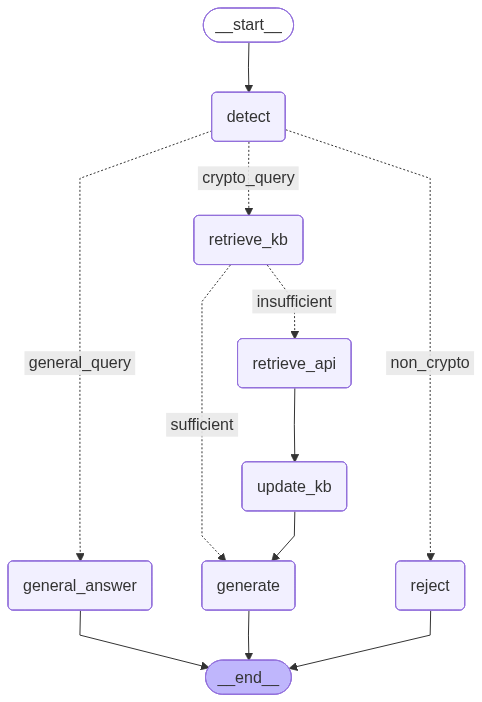

In [22]:
display(Image(agent.get_graph(xray=1).draw_mermaid_png()))

## **Testing**

- Test on valid crypto query

In [23]:
config = {"configurable": {"thread_id": "user123"}}

inputs = {
    "messages": [HumanMessage(content="What is the current price of Bitcoin?")]
}

result = agent.invoke(inputs, config=config)

In [24]:
Markdown(result['messages'][-1].content)

The current price of Bitcoin (BTC) is $89,728.78.

- Test on valid crypto subject query

In [25]:
config = {"configurable": {"thread_id": "user123"}}

inputs = {
    "messages": [HumanMessage(content="What is Marketspace?")]
}

result = agent.invoke(inputs, config=config)

In [27]:
Markdown(result["messages"][-1].content)

Marketspace (or Market.space) was a 2018 blockchain project aiming to create a decentralized data hosting and storage marketplace using cryptocurrency incentives.

- Test on non-crypto query

In [30]:
config = {"configurable": {"thread_id": "user123"}}

inputs = {
    "messages": [HumanMessage(content="What will be price of Solana in 2030?")]
}

result = agent.invoke(inputs, config=config)

In [31]:
Markdown(result["messages"][-1].content)


        Sorry, I can only help with current cryptocurrency price and market data questions at the moment.


        Try asking something like:

            • What's the price of Bitcoin?

            • How much is ETH right now?

            • Show me Solana 24h change
    